# Assignment 2 - Sample solution

In [1]:
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import mylib as my

from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib.colors import ListedColormap

from sklearn.ensemble import GradientBoostingClassifier

## PART A: Random forests: Out of bag score

Random forests (and bagging methods in general) can be evaluated by calculating the **out-of-bag** score. This score eliminates the need for a separate validation set or cross-validation. To compute it, follow these steps:

* For each example $x$ in the training set, identify the list of trees that were trained using samples that do not include $x$. In the context of these trees, $x$ is considered an unseen example and thus 'out of bag.'
* Apply the predict method to each of these trees to obtain a list of predictions for $x$.
* Determine the final prediction for $x` by selecting the class that appears most frequently among these predictions.

The accuracy of the final predictions for all out-of-bag examples is referred to as the out-of-bag score."

In this section of the assignment, your task is to calculate the out-of-bag score for a given random forest model and then compare it with the score calculated by SciKit Learn. To calculate this score manually, you will require access to the bootstrap samples used for training the random forest trees. However, SciKit Learn doesn't provide direct access to these samples. Instead, you can reconstruct them using the following function, which utilizes the `RandomState` that initially generated them.

In [2]:
import sklearn.ensemble._forest as forest_utils

def get_bootstrap_samples_indices(rf, n_samples):
    n_samples_bootstrap = forest_utils._get_n_samples_bootstrap(
        n_samples, rf.max_samples
    )

    bootstrap_sample_indices_per_tree = []
    for estimator in rf.estimators_:
        sampled_indices = forest_utils._generate_sample_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        bootstrap_sample_indices_per_tree.append(sampled_indices)
        
    return bootstrap_sample_indices_per_tree

Here is the model for which you will calculate the **out-of-bag** score. When setting the parameter `oob_score=True` in SciKit Learn, it instructs the library to compute the out-of-bag score for this model.

In [3]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=11)

Let's get started.

* **(5 points)** Load the iris dataset from `sklearn.datasets` and display the shapes of its input and output data.

In [4]:
iris = load_iris()
X, y = iris.data, iris.target

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (150, 4)
y shape: (150,)


* **(5 points)** Fit the above random forest model to the entire Iris dataset, and then utilize the `get_bootstrap_samples_indices()` function to regenerate the bootstrap samples used in training this model. Remember that an example is considered out-of-bag for a tree if it was not included in the bootstrap sample on which that tree was trained.

In [5]:
rf.fit(X, y)

samples = np.array(get_bootstrap_samples_indices(rf, 150))
print(samples.shape)

(50, 150)


* **(20 points)** Implement the logic that calculates the out-of-bag score as described above.

In [6]:
#initialize empty list(each element representing each row/'x' value) -> will be predicted label from trees that considered this 'x' oob
oob_predictions = []

for x_i in range(len(X)):
    #get estimators that this 'x' is considered oob
    estimators_oob_for = [estimator for estimator in rf.estimators_ if x_i not in np.unique(samples[rf.estimators_.index(estimator)])]
    
    #get predictions for current 'x' for each estimator that considered curr 'x' oob
    #need to reshape -> estimator expects 2D (but we're giving it 1D)
    #since we're giving 2D, it outputs 2D -> take 0th element (only element in result)
    oob_preds = [estimator.predict(X[x_i].reshape(1, -1))[0] for estimator in estimators_oob_for]
    
    #get majority for prediction
    oob_y = st.mode(oob_preds)
    
    #add pred to oob_predictions
    oob_predictions.append(oob_y)

* **(2 points)** Display your calculated out-of-bag score along with the score calculated by SciKit Learn, which you can access using the learned parameter `oob_score_`.

In [7]:
print(f'''
SciKit Learn's OOB score: {rf.oob_score_}
Manual OOB score: {accuracy_score(y, oob_predictions)}
''')


SciKit Learn's OOB score: 0.96
Manual OOB score: 0.96



## PART B: The effect of weak learners on boosting algorithms

Boosting algorithms such as AdaBoost require the use of **weak learners**. A weak learner is a model that performs slightly better than a random guess. In this section, you will investigate the effect of weak learners on boosting algorithms using the given XOR data below. 

In [8]:
X = np.random.uniform(-1, 1, size=(500, 2))
y = np.ones(len(X))

y[X[:, 0] * X[:, 1]< 0] =  0 

#y[y==0] = -1

This is simple linearly inseparable data that is known to cause problems for many classifiers. Let's get started:

* **(5 points)** Split this data in an 60/20/20 manner to three sets: training, validation, and testing.

In [9]:
train_idx = int(len(X) * .6)
valid_idx = int(len(X) * .2)

np.random.RandomState(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

train_i = indices[:train_idx]
valid_i = indices[train_idx:train_idx+valid_idx]
test_i = indices[train_idx+valid_idx:]

X_train, y_train = X[train_i], y[train_i]
X_valid, y_valid = X[valid_i], y[valid_i]
X_test, y_test = X[test_i], y[test_i]

print('train shapes:', X_train.shape, y_train.shape)
print('valid shapes:', X_valid.shape, y_valid.shape)
print('test shapes:', X_test.shape, y_test.shape)

train shapes: (300, 2) (300,)
valid shapes: (100, 2) (100,)
test shapes: (100, 2) (100,)


* **(5 points)** Train a very shallow decision tree  (with `max_depth=1`) on this data and print its training and validation accuracies.

In [10]:
#intialize dt
dt = DecisionTreeClassifier(max_depth=1)

#fit to training data
dt.fit(X_train, y_train)

#predict based on training
train_predictions = dt.predict(X_train)

#predict based on valid
valid_predictions = dt.predict(X_valid)

#output train/valid accuracies
print(f'''
Training accuracy: {accuracy_score(y_train, train_predictions)}
Validation accuracy: {accuracy_score(y_valid, valid_predictions)}
''')


Training accuracy: 0.59
Validation accuracy: 0.55



* **(8 points)** Create and show a figure with two side-by-side plots: one plotting the above tree and another plotting the training data and marking the split line indicated in the tree plot.

In [11]:
def plot_decision_regions(X, y, learner, resolution=0.1, title="Decision regions", ax=None, figsize=(16,8), plot_points=False):
    if X.ndim != 2:
        raise TypeError("Input data must be two-dimensional. That is the first X param can only have two features.")

    if y.ndim == 1:
        y = y.reshape(len(X), -1)
        
    D = np.concatenate([X, y], axis=1)
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    # Create color maps
    cmap_light = ListedColormap(['#79dfc1', '#feb272', '#a370f7', '#6ea8fe', '#dee2e6', '#ea868f'])
    cmap_bold = ListedColormap(['#20c997', '#fd7e14', '#6610f2', '#0d6efd', '#adb5bd', '#dc3545'])
    
    # Plot the decision boundary.
    x_min, x_max = D[:,0].min() - 1, D[:,0].max() + 1
    y_min, y_max = D[:,1].min() - 1, D[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    Z = learner.predict(np.array([xx.ravel(), yy.ravel()]).T)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.rcParams['pcolor.shading'] ='nearest'
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot the points
    if plot_points:
        ax.scatter(
            x=D[:, 0],
            y=D[:, 1], c=D[:,-1], cmap=cmap_bold,
            edgecolor='k', s=60)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # plt.legend(loc='best')
    if ax is None:
        plt.title(title)
    else:
        ax.set_title(title)

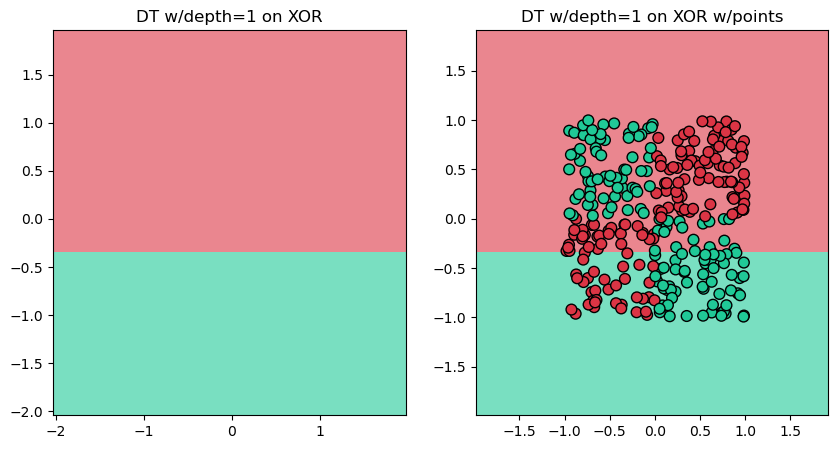

In [12]:
fig, subfigs = plt.subplots(1,2, figsize=(10, 5))

plot_decision_regions(X_train, y_train, dt, ax=subfigs[0], title='DT w/depth=1 on XOR')
plot_decision_regions(X_train, y_train, dt, ax=subfigs[1], title='DT w/depth=1 on XOR w/points', plot_points=True)
#subfigs[1].scatter(X_train[:, 0], X_train[:, 1], c=X_train)

* **(15 points)** Train multiple AdaBoost and Gradient Boosting classifiers with different values the `n_estimators` parameter. Vary the `n_estimators` values using `range(1, 300, 5)`. For every value: 
    * train an AdaBoost model using the previous decision tree as the base estimator.
    * train a gradient boosting model with a `max_depth=1` parameter. 
    
    
  Store the training and validation accuracies of these models and use them to plot the learning curves: `n_estimators` vs. accuracy. Use a figure with two side-by-side plots: one for AdaBoost's curves and another for Gradient Boosting's curves. Equip these plots with the necessary labels, titles, and legends.

In [13]:
class AdaBoostClassifier:
    def __init__(self, nTrees=20, maxDepth=1, enable_early_stopping=False):
        self.nTrees = nTrees
        self.stumps = []
        self.maxDepth = maxDepth
        self.early_stop = enable_early_stopping
        self.n = 5
        self.tol = 0.0001
        

    def misclassification_error(self, actual, predicted, w):
        error = w[(actual != predicted)].sum()
        return error if error != 0.0 else 0.000001

    def fit(self, X, y):
        """ Create weights """
        N = len(y)
        W = np.zeros((self.nTrees+1) * N).reshape(N, self.nTrees+1)
        
        """ Initially, weights are the same and they sum up to 1 """
        W[:, 0] = np.full(N, 1 / N)

        self.alpha_ = []
        for i in range(self.nTrees):
            """ Create stump and train it using weights """
            stump = DecisionTreeClassifier(max_depth=self.maxDepth)
            stump.fit(X, y, sample_weight=W[:, i])

            
            """ Calculate error """
            h = stump.predict(X)
            err = self.misclassification_error(y, h, W[:, i])
            
            """ Update alpha """
            alpha = .5 * np.log((1 - err) / err)
            self.alpha_.append(alpha)

            """ Update weights """
            W[:, i + 1] = W[:, i] * np.exp(-alpha * y * h)
            W[:, i + 1] = W[:, i + 1]/W[:, i + 1].sum()
            
            """ Save stump """
            self.stumps.append(stump)
        
        return self
    
    def predict(self, X_unseen):
        labels = np.zeros(len(X_unseen))
        for i in range(self.nTrees):
            labels += self.alpha_[i] * self.stumps[i].predict(X_unseen)
            
        return np.where(labels <= 0, -1, 1)

In [14]:
class SimpleGradientBoostingClassifier:
    def __init__(self, learning_rate, n_estimators, max_depth=2):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        self.F0 = np.log(y.mean()/(1-y.mean()))
        Fm = np.full(len(y), self.F0)
        
        for m in range(self.n_estimators):
            p = np.exp(Fm) / (1 + np.exp(Fm))
            rm = y - p  # Pseudo-residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(X, rm)
            
            # Getting the ids of the leaves and calculating gamma_jm
            ids = tree.apply(X)
            for j in np.unique(ids):
                top_sum = rm[ids == j].sum()
                bottom_sum = (p[ids == j]*(1-p[ids == j])).sum()
                gamma_jm = top_sum / bottom_sum

                Fm[ids == j] += self.learning_rate * gamma_jm

                # Replace gamma_jm for the predicted value the prediction value in the tree
                tree.tree_.value[j, 0, 0] = gamma_jm

            self.trees.append(tree)
            
        return self
    
    def predict(self, X_unseen):
        Fm = self.F0 + self.learning_rate * np.sum([tree.predict(X_unseen) for tree in self.trees], axis=0)
        p = np.exp(Fm) / (1 + np.exp(Fm))
        return np.where(p <= .5, 0, 1)

In [15]:
from tqdm import tqdm

ada_train_acc = []
ada_valid_acc = []

grad_train_acc = []
grad_valid_acc = []


for n_estimator in tqdm(range(1, 300, 5)):   
    for est in range(n_estimator):
        #--------adaboost--------
        ada = AdaBoostClassifier(nTrees=est).fit(X_train, y_train)
        
        #--------gradient boost---------
        gb = SimpleGradientBoostingClassifier(max_depth=1, learning_rate=0.3, n_estimators=n_estimator).fit(X_train, y_train)
        
    
    ada_train_acc.append(accuracy_score(np.where(y_train <= 0, -1, 1), ada.predict(X_train)))
    ada_valid_acc.append(accuracy_score(np.where(y_valid <= 0, -1, 1), ada.predict(X_valid)))
    grad_train_acc.append(accuracy_score(y_train, gb.predict(X_train)))
    grad_valid_acc.append(accuracy_score(y_valid, gb.predict(X_valid)))

100%|██████████| 60/60 [12:28<00:00, 12.48s/it]


Text(0.5, 1.0, 'Gradient Boost')

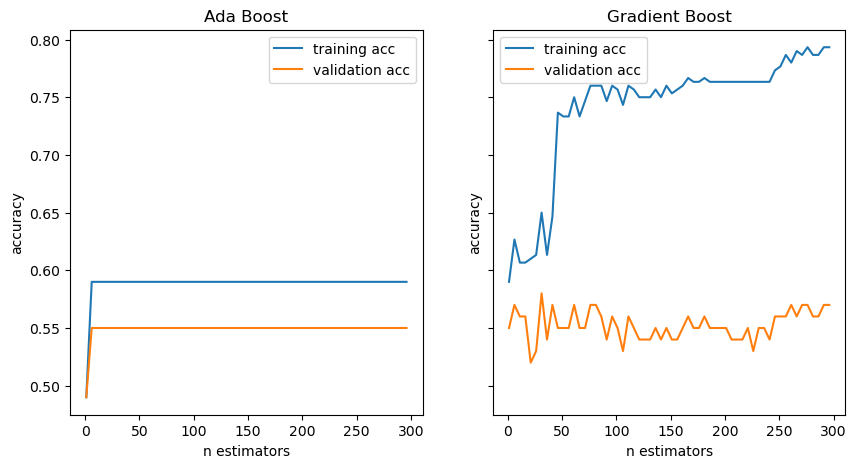

In [16]:
fig, subfigs = plt.subplots(1,2, figsize=(10, 5), sharey=True)

subfigs[0].plot(range(1, 300, 5), ada_train_acc, label='training acc')
subfigs[0].plot(range(1, 300, 5), ada_valid_acc, label='validation acc')
subfigs[0].set_xlabel('n estimators')
subfigs[0].set_ylabel('accuracy')
subfigs[0].legend()
subfigs[0].set_title('Ada Boost')

subfigs[1].plot(range(1, 300, 5), grad_train_acc, label='training acc')
subfigs[1].plot(range(1, 300, 5), grad_valid_acc, label='validation acc')
subfigs[1].set_xlabel('n estimators')
subfigs[1].set_ylabel('accuracy')
subfigs[1].legend()
subfigs[1].set_title('Gradient Boost')

* **(5 points)** Let's improve on the previous models by using better weak learners. Train a decision tree with a `max_depth=2`. Plot this tree and print its training and validation accuracies.

In [17]:
#intialize dt
dt = DecisionTreeClassifier(max_depth=2)

#fit to training data
dt.fit(X_train, y_train)

#predict based on training
train_predictions = dt.predict(X_train)

#predict based on valid
valid_predictions = dt.predict(X_valid)

#output train/valid accuracies
print(f'''
Training accuracy: {accuracy_score(y_train, train_predictions)}
Validation accuracy: {accuracy_score(y_valid, valid_predictions)}
''')


Training accuracy: 0.8433333333333334
Validation accuracy: 0.87



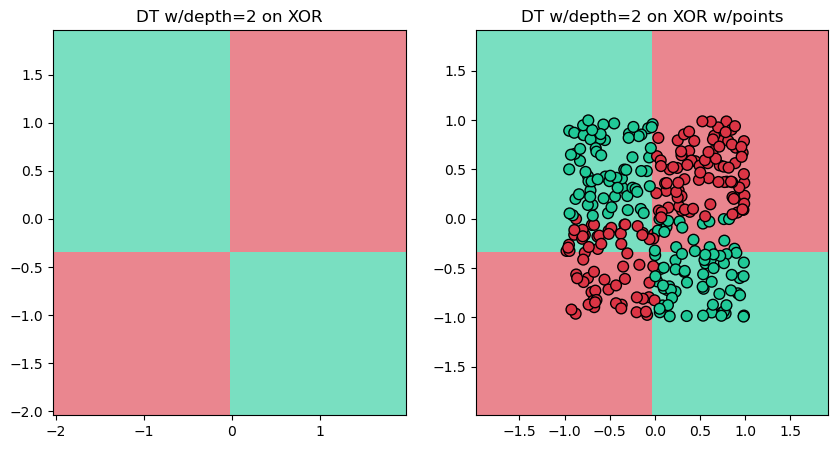

In [18]:
fig, subfigs = plt.subplots(1,2, figsize=(10, 5))

plot_decision_regions(X_train, y_train, dt, ax=subfigs[0], title='DT w/depth=2 on XOR')
plot_decision_regions(X_train, y_train, dt, ax=subfigs[1], title='DT w/depth=2 on XOR w/points', plot_points=True)
#subfigs[1].scatter(X_train[:, 0], X_train[:, 1], c=X_train)

* **(5 points)** Using decision trees with max-depth=2, train multiple AdaBoost and Gradient Boosting classifiers with varying values for `n_estimators` in the same way as before. Plot the learning curves.

In [19]:
ada_train_acc = []
ada_valid_acc = []

grad_train_acc = []
grad_valid_acc = []


for n_estimator in tqdm(range(1, 300, 5)):   
    for est in range(n_estimator):
        #--------adaboost--------
        ada = AdaBoostClassifier(nTrees=est, maxDepth=2).fit(X_train, y_train)
        
        #--------gradient boost---------
        gb = SimpleGradientBoostingClassifier(max_depth=2, learning_rate=0.3, n_estimators=n_estimator).fit(X_train, y_train)
        
    
    ada_train_acc.append(accuracy_score(np.where(y_train <= 0, -1, 1), ada.predict(X_train)))
    ada_valid_acc.append(accuracy_score(np.where(y_valid <= 0, -1, 1), ada.predict(X_valid)))
    grad_train_acc.append(accuracy_score(y_train, gb.predict(X_train)))
    grad_valid_acc.append(accuracy_score(y_valid, gb.predict(X_valid)))

100%|██████████| 60/60 [13:47<00:00, 13.78s/it]


Text(0.5, 1.0, 'Gradient Boost')

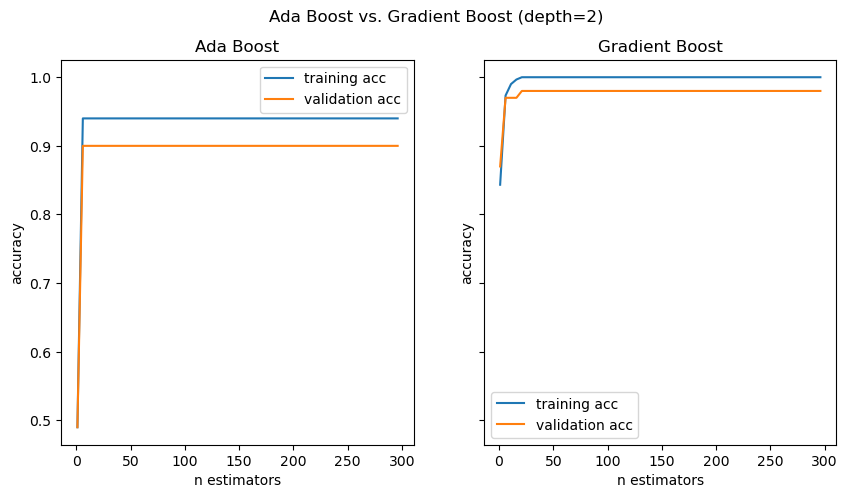

In [20]:
fig, subfigs = plt.subplots(1,2, figsize=(10, 5), sharey=True)

fig.suptitle('Ada Boost vs. Gradient Boost (depth=2)')

subfigs[0].plot(range(1, 300, 5), ada_train_acc, label='training acc')
subfigs[0].plot(range(1, 300, 5), ada_valid_acc, label='validation acc')
subfigs[0].set_xlabel('n estimators')
subfigs[0].set_ylabel('accuracy')
subfigs[0].legend()
subfigs[0].set_title('Ada Boost')

subfigs[1].plot(range(1, 300, 5), grad_train_acc, label='training acc')
subfigs[1].plot(range(1, 300, 5), grad_valid_acc, label='validation acc')
subfigs[1].set_xlabel('n estimators')
subfigs[1].set_ylabel('accuracy')
subfigs[1].legend()
subfigs[1].set_title('Gradient Boost')

## PART C: Combating overfitting with early stopping

The last results are much better, but how can we find a good value for the `n_estimator` parameter so that we are not wasting time and resources? In this section, we will implement a technique called early stopping for this purpose. Early stopping gives us another reason to have a validation set. Some models, like gradient boosting and neural networks (as we will see), come with built-in support for it. You  will enable early stopping on gradient boosting models and implement it manually for AdaBoost.

* **(5 points)** First, Train a gradient boosting model with early stopping using a value of 500 for `n_estimators`. Refer to SciKit Learn's documentation page for this model on what parameter(s) to use to enable early-stopping.  Use a tolerance value of 0.0001.

In [21]:
gb = GradientBoostingClassifier(n_estimators=500, 
                                 validation_fraction=0.1,  # Fraction of training data used for early stopping
                                 n_iter_no_change=5,  # Number of iterations with no improvement on the validation set
                                 tol=1e-4,
                                 random_state=42)

gb.fit(X_train, y_train)

accuracy_score(y_train, gb.predict(X_train))
accuracy_score(y_valid, gb.predict(X_valid))

print(f'''
Training accuracy: {accuracy_score(y_train, gb.predict(X_train))}
Validation accuracy: {accuracy_score(y_valid, gb.predict(X_valid))}
''')


Training accuracy: 1.0
Validation accuracy: 1.0




* **(20 points)** Secondly, `AdaBoostClassifier` does come with built-in support for early stopping, so you will implement it. The idea is simple. Inside the loop that iterates over the `n_estimators` values, save the last `n` validation accuracies. Then compare them to one another. If they happen to be within a given tolerance difference from one another, then quit the loop. Otherwise, continue. Use `n = 5` and `tolerance = 0.0001`. Plot the training and validation accuracies just like you did before but stop these curves at the value of `n_estimators` that your code stopped at. Print that value as well.

In [22]:
ada_train_acc = []
ada_valid_acc = []

n_estimators_ = []

n_iters_without_improvement = 0
best_accuracy = 0
tolerance = 0.0001
n_max_consecutive_iters = 5

for n_estimator in tqdm(range(1, 300, 5)):   
    for est in range(n_estimator):
        #--------adaboost--------
        ada = AdaBoostClassifier(nTrees=est, maxDepth=2).fit(X_train, y_train)
        
    n_estimators_.append(n_estimator)
    ada_train_acc.append(accuracy_score(np.where(y_train <= 0, -1, 1), ada.predict(X_train)))
    ada_valid_acc.append(accuracy_score(np.where(y_valid <= 0, -1, 1), ada.predict(X_valid)))
    
    #if new best acc -> reset counter
    #else: add 1 to counter
    if ada_valid_acc[-1] > best_accuracy:
        best_accuracy = ada_valid_acc[-1]
        n_iters_without_improvement = 0
    else:
        n_iters_without_improvement += 1
    
    if len(ada_valid_acc) > 1:
        #if improvement < tolerance or hit max n consecutive iters: break
        if (ada_valid_acc[-1] - ada_valid_acc[-2] < tolerance) or (n_iters_without_improvement >= n_max_consecutive_iters):
            break
    

  3%|▎         | 2/60 [00:00<00:00, 64.51it/s]


Text(0.5, 1.0, 'Ada Boost')

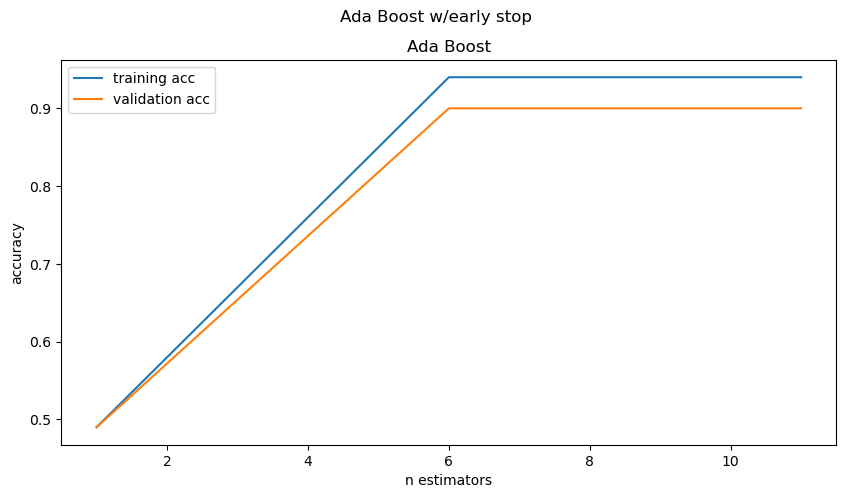

In [23]:
fig, subfigs = plt.subplots(1,1, figsize=(10, 5), sharey=True)

fig.suptitle('Ada Boost w/early stop')

subfigs.plot(n_estimators_, ada_train_acc, label='training acc')
subfigs.plot(n_estimators_, ada_valid_acc, label='validation acc')
subfigs.set_xlabel('n estimators')
subfigs.set_ylabel('accuracy')
subfigs.legend()
subfigs.set_title('Ada Boost')
